# Analysis of M66 (NGC 3627) with JWST

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import glob
import shutil

from astroquery.mast import Observations
from astropy.io import fits

from XRBID.AutoPhots import RunPhots, DaoFindObjects
from XRBID.WriteScript import (WriteReg, WriteDS9,
                              WriteScalings)
from XRBID.Sources import (LoadSources, GetCoords, GetIDs,
                           DaoClean, Crossref)
from XRBID.DataFrameMod import (RemoveElse, FindUnique, BuildFrame,
                                Find)
from XRBID.Align import CorrectAstrometry, CalcPU

from photometry_utils import instrument_info

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"

# jwst directories
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# hst directories
f275w = hstdir+"M66_mosaic_uvis_f275w_drc_sci.fits"
f336w = hstdir+"M66_mosaic_uvis_f336w_drc_sci.fits"
f438w = hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"
f814w = hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits"

## Notes

**Photometry**: <br>
- links for [conversion](https://jwst-docs.stsci.edu/jwst-near-infrared-camera#gsc.tab=0) and [filters](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-filters#gsc.tab=0).
- short wavelength pix conversion = 0.031''/pixel
- long wavelength pix conversion = 0.063''/pixel

**Infrared Object identification**
- I found SNRs in M66 which I should take a look at while doing the infrared object identifcation. They can be found on the wikipedia page for M66. 

**JWST**
- Found encircled energy fractions from [here](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-point-spread-functions#NIRCamPointSpreadFunctions-Encircledenergy).
- Zeropoints can be found here : [zeropoints](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-absolute-flux-calibration-and-zeropoints)
- 
**Misc**
- Always keep in mind that coordinates are flipped in a fits image
- Learn how to import functions

## Things to confirm
1. The Astrometric Corrections: In my original run of CorrectAstrometry, I realised that 
(a) the code was not using the base coordinates of the double star calibrators for the base coordinates and was instead using the base coordinates of a nearby source (which is not even a star) and,
(b) one of the calibrator ("2CXO J112018.3+125900") is not even being used for the calculation, which I believe is because the separation of the source is not between the minimum and the maximum separation. 
Through this method, the median offset was bigger than the standard deviation so I needed to apply astrometric corrections. <br>
HOWEVER, to counter that, I just created a list of the coordinates of the daofind sources that I found manually to pass as the base coordinates. Through this method, the median offset in the x and y coordinates was smaller than the standard deviation and therefore, no correction is needed and I can keep going forward with the analysis.

2. Confirm if the astrocorrect regions are alright. Maybe ask for help with how it should be properly done.
3. See cross referencing outputs
4. **Unsure**: I am not sure about the pixel conversion underneath. This should be correct for the F200W sources but what about the long wavelength sources?

## Querying JWST Data

In [ ]:
%%time

filters = ["F150W", "F200W", "F150W", "F277W", "F444W"
           "F300M", "F335M", "F360M",
           "F187N", "F212N"]
proposal_id = [2107, 4793]
print("Finding observations for JWST images...")
obs_table = Observations.query_criteria(objectname="M66", obs_collection="JWST",
                                        filters=filters, proposal_id=proposal_id,
                                        instrument_name="NIRCAM/IMAGE")
print("Done")

Finding observations for JWST images...


In [5]:
obs_table

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str7,str12,str4,str5,str8,str8,str84,str36,float64,float64,str5,str15,int64,float64,float64,float64,float64,float64,str105,float64,str4,str2,int64,str115,str62,str63,str6,bool,float64,str9,str9,str9,float64
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F150W,INFRARED,NGC-3627,Galaxy; Active galactic nuclei; Disk galaxies; Interacting galaxies; Spiral galaxies,jw04793-o011_t011_nircam_clear-f150w,170.06235,12.991538888888888,image,"Schinnerer, Eva",3,60665.7612082816,60665.776121145835,858.9439999999997,1331.0,1668.0,Unveiling the physics that govern massive star-formation in extragalactic Central Molecular Zones (eCMZs),60666.06984949,4793,GO,--,POLYGON 170.072869366 12.963631618 170.03292137 12.978889968 170.048625314 13.017934287 170.088578625 13.002673538,mast:JWST/product/jw04793-o011_t011_nircam_clear-f150w_i2d.jpg,mast:JWST/product/jw04793-o011_t011_nircam_clear-f150w_i2d.fits,PUBLIC,False,nan,234389769,793836430,793836430,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F360M,INFRARED,NGC-3627,Galaxy; Spiral galaxies,jw02107-o029_t011_nircam_clear-f360m,170.06010458333333,12.983758333333332,image,"Lee, Janice",3,59957.60078729606,59957.65987877315,858.9439999999996,3427.0,3814.0,A JWST-HST-VLT/MUSE-ALMA Treasury of Star Formation in Nearby Galaxies,59960.26373838,2107,GO,--,POLYGON 170.064025948 12.942315942 170.02645268 12.956365371 170.052701715 13.023033291 170.090283579 13.008980093,mast:JWST/product/jw02107-o029_t011_nircam_clear-f360m_i2d.jpg,mast:JWST/product/jw02107-o029_t011_nircam_clear-f360m_i2d.fits,PUBLIC,False,nan,109508031,747060856,747060856,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F200W,INFRARED,NGC-3627,Galaxy; Spiral galaxies,jw02107-o029_t011_nircam_clear-f200w,170.06010458333333,12.983758333333332,image,"Lee, Janice",3,59957.600786555326,59957.68150171296,2405.0399999999995,1755.0,2226.0,A JWST-HST-VLT/MUSE-ALMA Treasury of Star Formation in Nearby Galaxies,59960.26373838,2107,GO,--,POLYGON 170.064228842 12.942098631 170.025897491 12.956670458 170.052784974 13.023840005 170.09112511 13.009264239,mast:JWST/product/jw02107-o029_t011_nircam_clear-f200w_i2d.jpg,mast:JWST/product/jw02107-o029_t011_nircam_clear-f200w_i2d.fits,PUBLIC,False,nan,109507984,747060759,747060759,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F335M,INFRARED,NGC-3627,Galaxy; Active galactic nuclei; Disk galaxies; Interacting galaxies; Spiral galaxies,jw04793-o011_t011_nircam_clear-f335m,170.06235,12.991538888888888,image,"Schinnerer, Eva",3,60665.70665361806,60665.730638229164,1631.992,3177.0,3538.0,Unveiling the physics that govern massive star-formation in extragalactic Central Molecular Zones (eCMZs),60666.06984949,4793,GO,--,POLYGON 170.072667126 12.963856686 170.033312403 12.978642692 170.048534577 13.017118324 170.08789449 13.002330028,mast:JWST/product/jw04793-o011_t011_nircam_clear-f335m_i2d.jpg,mast:JWST/product/jw04793-o011_t011_nircam_clear-f335m_i2d.fits,PUBLIC,False,nan,234389745,793836338,793836338,0.0
science,JWST,CALJWST,NIRCAM/IMAGE,JWST,F212N,INFRARED,NGC-3627,Galaxy; Active galactic nuclei; Disk galaxies; Interacting galaxies; Spiral galaxies,jw04793-o011_t011_nircam_clear-f212n,170.06235,12.991538888888888,image,"Schinnerer, Eva",3,60665.7343661875,60665.75835078704,1631.992,2109.0,2134.0,Unveiling the physics that govern massive star-formation in extragalactic Central Molecular Zones (eCMZs),60666.06984949,4793,GO,--,POLYGON 170.072869214 12.963632641 170.032918963 12.978891781 170.048622441 13.017935126 170.088578008 13.002673587,mast:JWST/product/jw04793-o011_t011_nircam_clear-f212n_i2d.jpg,mast:JWST/product/jw04793-o011_t011_nircam_clear-f212n_i2d.fits,P

In [6]:
# The code is downloading many extra files that are not needed. 
print("Downloading data.\n This may take several minutes... \n")
products = Observations.get_product_list(obs_table)

data_prod = ['I2D']       # other options are ['FLT','DRC','DRZ']
data_type = ['CALJWST']   # other options are ['CALACS','CALWF3','CALWP2']

Observations.download_products(products, project=data_type, 
                               productSubGroupDescription=data_prod)
print("Done")

 This may take several minutes... 



obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str5,str36,str64,str1,str69,str9,str28,str11,str1,str7,str6,str4,str51,int64,str9,str6,int64,str5
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS1 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq1_2023013152509_stream.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2107,jw02107029002_gs-acq1_2023013152509_stream.fits,408960,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS1 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq1_2023013152509_uncal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2107,jw02107029002_gs-acq1_2023013152509_uncal.fits,420480,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS1 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq1_2023013152509_cal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,1.17.1,2107,jw02107029002_gs-acq1_2023013152509_cal.fits,1284480,109507984,PUBLIC,2,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS2 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq2_2023013152511_stream.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,--,2107,jw02107029002_gs-acq2_2023013152511_stream.fits,37440,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS2 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq2_2023013152511_uncal.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,--,2107,jw02107029002_gs-acq2_2023013152511_uncal.fits,48960,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS2 guide star acquisition,S,mast:JWST/product/jw02107029002_gs-acq2_2023013152511_cal.fits,AUXILIARY,--,GS-ACQ2,--,CALJWST,1.17.1,2107,jw02107029002_gs-acq2_2023013152511_cal.fits,106560,109507984,PUBLIC,2,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS guide star fine guide,S,mast:JWST/product/jw02107029002_gs-fg_2023013153039_stream.fits,AUXILIARY,--,GS-FG,--,CALJWST,--,2107,jw02107029002_gs-fg_2023013153039_stream.fits,4731840,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS guide star fine guide,S,mast:JWST/product/jw02107029002_gs-fg_2023013153039_uncal.fits,AUXILIARY,--,GS-FG,--,CALJWST,--,2107,jw02107029002_gs-fg_2023013153039_uncal.fits,5964480,109507984,PUBLIC,1,F200W
109081772,JWST,image,jw02107029002_04101_00004_nrcb4,FGS guide star fine guide,S,mast:JWST/product/jw02107029002_gs-fg_2023013153258_stream.fits,AUXILIARY,--,GS-FG,--,CALJWST,--,2107,jw02107029002_gs-fg_2023013153258_stream.fits,1589760,109507984,PUBLIC,1,F200W


Since the above code is downloading additional files that are not required, I am manually downloading data from this [link](https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table) for M66. 

The filters that I am using are: 360m, 335m, 300m, 200w

# Photometry

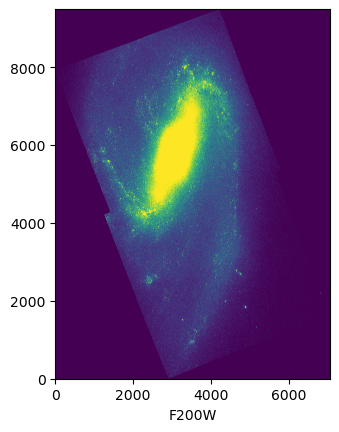

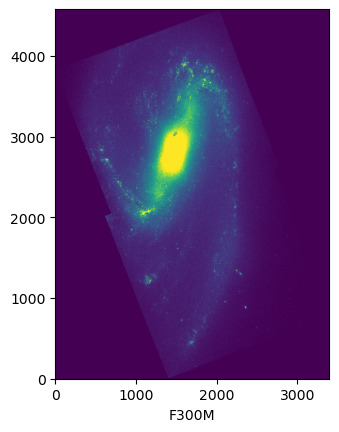

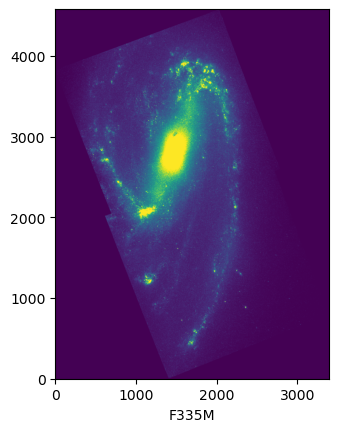

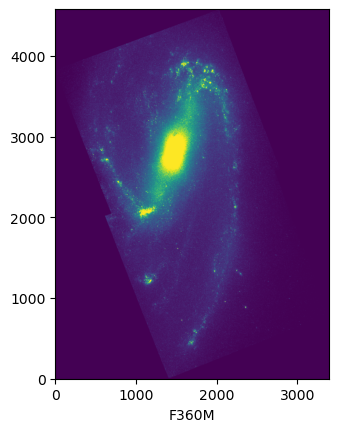

In [73]:
# just to see how the images look like
images = {
          "F200W" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits",
          "F300M" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits",
          "F335M" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits",
          "F360M" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"
}

for filter in images:
    hdu = fits.open(images[filter])
    data = hdu['sci'].data
    plt.imshow(data, origin='lower', vmin=0, vmax=10)
    plt.xlabel(filter)
    plt.show()

# def create_images(images, nrows, ncols, vmin, vmax):
#     ax, fig = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4,6))

#     for i, filter in enumerate(images):
#         hdu_image[i] = fits.getdata(images[filter])
#         ax[i].imshow(hdu_image, vmin=vmin, vmax=vmax)
#         ax[i].xlabel(images[filter])
#         plt.show

# create_images(images, nrows=2, ncols=2, vmin=0, vmax=10)

## JWST

### F200W

0.14


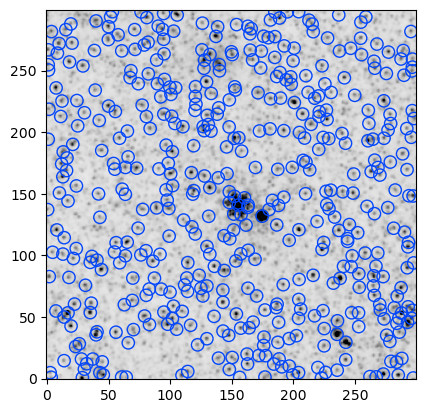

In [2]:
# I am satisfied with this configuration.

data = fits.getdata(f200w)
data = data[3200:3500, 3000:3300]
pixtoarcs = 0.031 # arcseconds for JWST Nircam short wavelength filters
fwhm = 0.14
print(fwhm)
objects = DaoFindObjects(data, fwhm=fwhm, pixtoarcs=pixtoarcs, plot=True, vmax=10)

In [2]:
cd(jwstdir)

In [ ]:
hdu_f200w = fits.open(f200w)
zeropoint = np.mean([25.55, 25.56, 25.60, 25.66])
apcorr, apcorr_err, apcorr_ext, aperr_ext = RunPhots(hdu_f200w, gal='M66', instrument='NIRCAM', filter='F200W',
                                                     fwhm_arcs=0.14, zeropoint=zeropoint, reg_correction=[0,1],
                                                     suffix='_test1', extended_rad=5)
hdu_f200w.close()

In [68]:
apcorr, apcorr_err, apcorr_ext, aperr_ext

((np.float64(-0.9432533390429116),),
 np.float64(0.22063308967907644),
 np.float64(-0.6547372320991942),
 np.float64(0.183335676482875))

### F300M - long filter

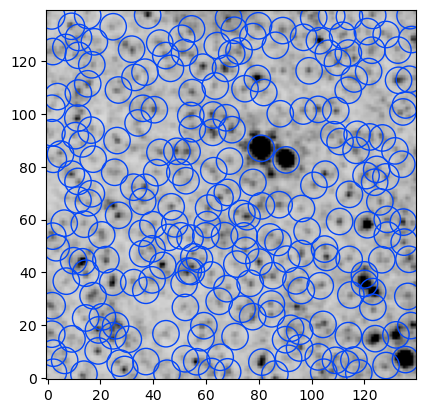

In [9]:
data = fits.getdata(f300m)
data = data[1530:1670, 1430:1570]
pixtoarcs = 0.063 # arcseconds for JWST Nircam long wavelength filters
fwhm = 0.3
objects = DaoFindObjects(data, fwhm=fwhm, threshold=2, pixtoarcs=pixtoarcs, plot=True, vmax=3.5)

In [10]:
instrument_info(f300m)

Instrument: NIRCAM 
Detector: NRCBLONG 
Module: B 
Channel: LONG 
Filter: F300M 
Pupil: CLEAR


In [ ]:
hdu = fits.open(f300m)
zeropoint = 24.04
# Test 1: I like the image coordinates that this output gives
apcorr, aperr, apcorr_ext, aperr_ext = RunPhots(hdu, gal='M66', instrument='NIRCAM', filter='F300M',
                                               fwhm_arcs=0.3, threshold=2, zeropoint=zeropoint,
                                               reg_correction=[1,1], extended_rad=5)

In [30]:
apcorr, aperr, apcorr_ext, aperr_ext

((np.float64(-0.78481712836287),),
 np.float64(0.306933205838483),
 np.float64(-0.5282181244768287),
 np.float64(0.2260012288120479))

1. CorrectAp: suffix parameter
2. Unitsfor photometry in RunPhots
3. small errors: 0.2 and 0.15 are good!
4. M101, M83 and M81 - I can do jwst analysis next!
5. SNR
6. strict moment 6

### F335M - long filter
Date: 23 May 2025

In [88]:
instrument_info(f335m)

Instrument: NIRCAM 
Detector: NRCBLONG 
Module: B 
Channel: LONG 
Filter: F335M 
Pupil: CLEAR


In [ ]:
hdu = fits.open(f335m)
zeropoint = 23.95

apcorr, aperr, apcorr_ext, aperr_ext = RunPhots(hdu, gal='M66', instrument='NIRCAM', filter='F335M',
                                               fwhm_arcs=0.3, threshold=2, zeropoint=zeropoint,
                                               reg_correction=[1,1], extended_rad=5, suffix='_test1')

In [ ]:
apcorr, aperr, apcorr_ext, aperr_ext

((np.float64(-0.9755221853576381),),
 np.float64(0.37631401061577546),
 np.float64(-0.6818044171522375),
 np.float64(0.2791374036787237))

### F360M - long filter

In [49]:
instrument_info(f360m)

Instrument: NIRCAM 
Detector: NRCBLONG 
Module: B 
Channel: LONG 
Filter: F360M 
Pupil: CLEAR


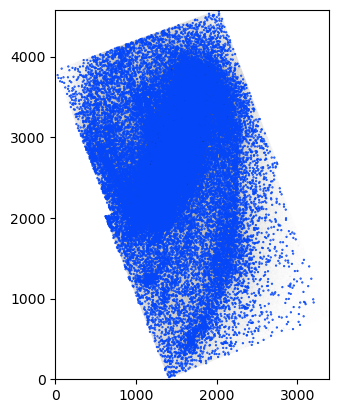

31982

In [47]:
data = fits.getdata(f360m)
# data = data[1550:1670, 1450:1660]
pixtoarcs = 0.063 # arcseconds for JWST Nircam long wavelength filters
objects = DaoFindObjects(data, fwhm=0.3, threshold=2, pixtoarcs=pixtoarcs, plot=True, vmax=3.5)
len(objects)

In [ ]:
hdu_f360m = fits.open(f360m)
zeropoint = 23.77
apcorr, aperr, apcorr_ext, aperr_ext = RunPhots(hdu_f360m, gal='M66', instrument='NIRCAM', filter='F360M',
                                               fwhm_arcs=0.3, threshold=2, zeropoint=zeropoint,
                                               reg_correction=[1,1], extended_rad=5, suffix='_test1')

In [55]:
apcorr, aperr, apcorr_ext, aperr_ext

((np.float64(-0.8656525139120455),),
 np.float64(0.28681072980075817),
 np.float64(-0.6430972067239484),
 np.float64(0.2291155826238405))

## HST

### F814W

In [94]:
f814w

'/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST/M66_mosaic_uvis_f814w_drc_sci.fits'

In [ ]:
f814w_data = fits.getdata(f814w)
f814w_data_sliced = f814w_data[3400:3700, 4400:4700]
pixtoarcs = 0.03962
f814w_objects = DaoFindObjects(f814w_data_sliced, fwhm=0.10*2, pixtoarcs=pixtoarcs, threshold=2, plot=True)

# investigating the daofind sources and extracting their photometry
f814w_hdu = fits.open(f814w)
apcorr, aperr, apcorr_ext, aperr_ext = RunPhots(f814w_hdu, gal="M66", instrument="WFC3",
                                               filter='F814W', fwhm_arcs=0.10*2, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f814w_hdu.close()

In [3]:
apcorr, aperr, apcorr_ext, aperr_ext

((np.float64(-0.8588325849729528),),
 np.float64(0.1807607521654574),
 np.float64(-0.3719457463759386),
 np.float64(0.10642947110641915))

### F555W

In [ ]:
f555w_data = fits.getdata(f555w)
f555w_data_sliced = f555w_data[3400:3700, 4400:4700]
pixtoarcs = 0.03962
fwhm = 0.18 * 2 # originally found 0.18 arcsec through ds9
f555w_objects = DaoFindObjects(f555w_data_sliced, fwhm=fwhm, pixtoarcs=pixtoarcs,
                               threshold=2, plot=True)

#investigating the daofind sources and extracting their photometry
f555w_hdu = fits.open(f555w)
apcorr555w, aperr555w, apcorr_ext555w, aperr_ext555w = RunPhots(f555w_hdu, gal="M66", instrument="WFC3",
                                               filter='F555W', fwhm_arcs=fwhm, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f555w_hdu.close()

In [11]:
apcorr555w, aperr555w, apcorr_ext555w, aperr_ext555w

((np.float64(-0.8814290765714752),),
 np.float64(0.24055442323969883),
 np.float64(-0.3472747023393392),
 np.float64(0.12601848622183956))

### F438W

In [ ]:
f438w_data = fits.getdata(f438w)
f438w_data_sliced = f438w_data[3400:3700, 4400:4700]
pixtoarcs = 0.03962
fwhm = 0.11 * 2 # originally found 0.18 arcsec through ds9
f438w_objects = DaoFindObjects(f438w_data_sliced, fwhm=fwhm, pixtoarcs=pixtoarcs,
                               threshold=2, plot=True, vmax=0.09)
print(len(f438w_objects)) # found with 195 sources fwhm=0.10

#investigating the daofind sources and extracting their photometry
f438w_hdu = fits.open(f438w)
apcorr438w, aperr438w, apcorr_ext438w, aperr_ext438w = RunPhots(f438w_hdu, gal="M66", instrument="WFC3",
                                               filter='F438W', fwhm_arcs=fwhm, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f438w_hdu.close()

In [45]:
apcorr438w, aperr438w, apcorr_ext438w, aperr_ext438w

((np.float64(-0.9175731144364969),),
 np.float64(0.2291917542835823),
 np.float64(-0.4745254777532202),
 np.float64(0.15543813531799572))

### F336W

In [ ]:
f336w_data = fits.getdata(f336w)
f336w_data_sliced = f336w_data[3400:3700, 4400:4700]
pixtoarcs = 0.03962
fwhm = 0.12 * 2 # originally found 0.18 arcsec through ds9
f336w_objects = DaoFindObjects(f336w_data_sliced, fwhm=fwhm, pixtoarcs=pixtoarcs,
                               threshold=2, plot=True, vmax=0.05)
print(len(f336w_objects)) # found with 195 sources fwhm=0.10

# investigating the daofind sources and extracting their photometry
f336w_hdu = fits.open(f336w)
apcorr336w, aperr336w, apcorr_ext336w, aperr_ext336w = RunPhots(f336w_hdu, gal="M66", instrument="WFC3",
                                               filter='F336W', fwhm_arcs=fwhm, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f336w_hdu.close()

In [60]:
apcorr336w, aperr336w, apcorr_ext336w, aperr_ext336w 

((np.float64(-0.9540754478692428),),
 np.float64(0.23448030394882666),
 np.float64(-0.43512525755218445),
 np.float64(0.13649683194194648))

### F275W

In [ ]:
f275w_data = fits.getdata(f275w)
f275w_data_sliced = f275w_data[4400:5000, 4300:4900]
pixtoarcs = 0.03962
fwhm = 0.12 * 2 # originally found 0.18 arcsec through ds9
f275w_objects = DaoFindObjects(f275w_data_sliced, fwhm=fwhm, pixtoarcs=pixtoarcs,
                               threshold=2, plot=True, vmax=0.015)
print(len(f275w_objects)) # found with 195 sources fwhm=0.10

#investigating the daofind sources and extracting their photometry
f275w_hdu = fits.open(f275w)
apcorr275w, aperr275w, apcorr_ext275w, aperr_ext275w = RunPhots(f275w_hdu, gal="M66", instrument="WFC3",
                                               filter='F275W', fwhm_arcs=fwhm, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f275w_hdu.close()

In [66]:
apcorr275w, aperr275w, apcorr_ext275w, aperr_ext275w

((np.float64(-0.9707309801124901),),
 np.float64(0.25887846989477437),
 np.float64(-0.4419304737417187),
 np.float64(0.1511766174865048))

# Questionable Astrometric Corrections 

Check the notes above. 

In [116]:
chandradir

'/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/'

In [ ]:
M66_CSC = LoadSources(chandradir+"cscresults_M66_renamed.frame")

# Find X-ray sources with a unique CSC ID,
# in case multiple rows in the the DataFrame have the same CSC ID
M66_unique = FindUnique(M66_CSC, header="CSC ID")

# # # Saving M66 to a region file that can be opened in DS9
WriteReg(M66_unique, outfile=chandradir+"M66_cscsources.reg", idheader="CSC ID", 
         radius=0.2, radunit="arcsec", width=2, color="hotpink")

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/cscresults_M66_renamed.frame...


In [169]:
M66_calibrators = ["2CXO J112014.8+125814",
                   "2CXO J112013.0+125736",
                   "2CXO J112017.5+125818",
                  # "2CXO J112011.8+125811", # Maybe I can exclude this as well
                   "2CXO J112012.3+125846",
                   #"2CXO J112019.5+125958", # Can exclude this as well 
                   "2CXO J112018.3+125900"] 

# M66 calibrators that I used in the Optical-X-ray analysis
# M66_calibrators = ['2CXO J112018.9+130135',
#                    '2CXO J112018.3+125900',
#                    '2CXO J112014.8+125814',
#                    '2CXO J112013.0+125736']

print(len(M66_calibrators))

M66_calibrators = RemoveElse(M66_unique, keep=M66_calibrators, header='CSC ID')
print(len(M66_calibrators))

WriteReg(M66_calibrators, outfile=chandradir+'M66_calibrators.reg',
         radius=1.0, width=2)

5
5
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_calibrators.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_calibrators.reg saved!


Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/M66_daofind_f200w_nircam_fk5.reg


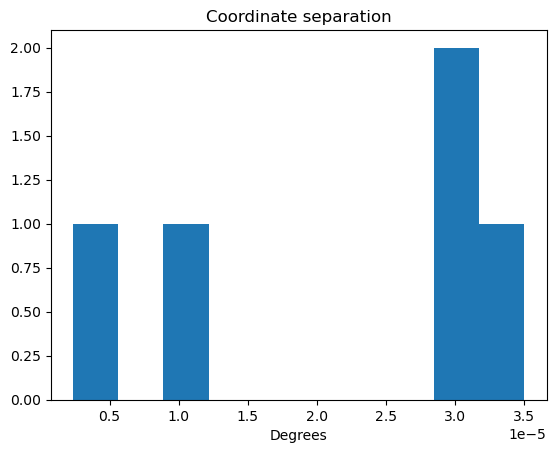

Median separation: 2.9589318165433735e-05


Input min and max separation: 0.2e-5, 3.5e-5


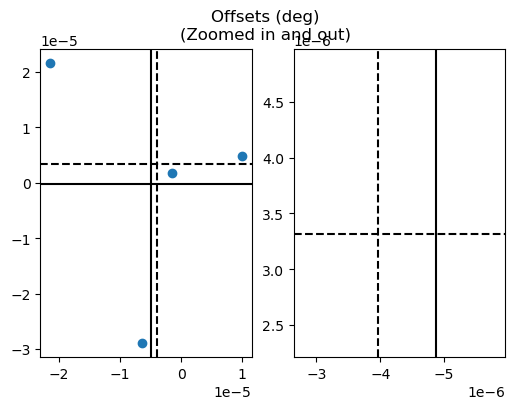

Median offsets in x and y (deg): -3.9699339566823255e-06 3.316214594484279e-06


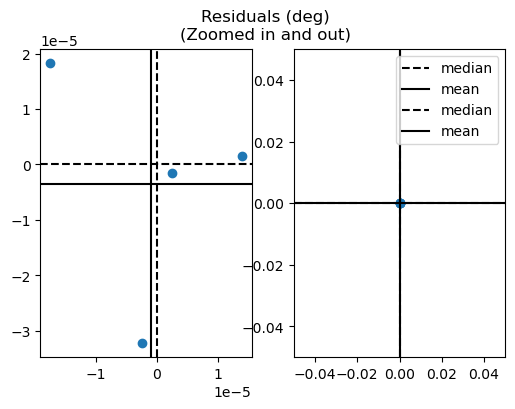

Min and max x residuals: -1.8e-5, 1.3e-5
Min and max y residuals: -3.2e-5, 1.8e-5



RESULTS OF ASTROMETRY CORRECTION

Median offsets in x and y:
 -3.9699339566823255e-06 3.316214594484279e-06 degrees
 -0.014291762244056372 0.011938372540143405 arcsecs

Standard deviation in x and y offsets:
 8.489123407893624e-06 1.4701043644649303e-06 degrees
 0.03056084426841705 0.005292375712073749 arcsecs

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_astrocorrect.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_astrocorrect.reg saved!
Check region file for correct assessments.


(np.float64(-3.9699339566823255e-06),
 np.float64(3.316214594484279e-06),
 np.float64(8.489123407893624e-06),
 np.float64(1.4701043644649303e-06))

In [ ]:
base_coords = GetCoords(jwstdir+"M66_daofind_f200w_nircam_fk5.reg")
cat_coords = [M66_calibrators["RA"].values.tolist(), 
              M66_calibrators["Dec"].values.tolist()]
CorrectAstrometry(base_coords, cat_coords, returnshifts=True, autoresid=False,
                  savebasereg=chandradir+"M66_astrocorrect.reg")

Since the median offsets in the x and y directions are so small in comparison to their respective standard deviations, there is no need to add these offsets. However, one thing that I noticed that for the 2CXO J112014.8+125814 calibrator, the X-ray source is selecting another source which is not the star. 

In [4]:
# Add the Y offset 
M66_shifted = M66_unique.copy() 
M66_shifted['Dec'] = M66_unique['Dec'] + 3.316214594484279e-06
M66_shifted

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_lolim_b,flux_aper_avg_hilim_b,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim
0,0.603512,2CXO J112014.9+125929,170.062428,12.991498,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,2.158629e-14,2.700286e-14,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641
1,1.154310,2CXO J112015.0+125928,170.062878,12.991332,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,2.096613e-14,2.689218e-14,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784
2,4.249587,2CXO J112014.9+125933,170.062259,12.992636,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,2.943952e-14,3.440386e-14,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992192,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,2.366824e-13,2.788378e-13,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381
4,5.940189,2CXO J112015.3+125932,170.064119,12.992233,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,5.671396e-15,8.390559e-15,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003666,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,2.248525e-15,4.208778e-15,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527
84,237.496980,2CXO J112008.5+130307,170.035399,13.051918,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,4.359917e-15,7.956849e-15,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982
85,240.218881,2CXO J112019.6+130320,170.081736,13.055573,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,3.837669e-14,4.670929e-14,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744
86,246.797558,2CXO J112027.8+125649,170.116113,12.947002,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,1.775502e-15,4.142838e-15,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118


In [12]:
# Create a region file with the shifted coordinates
# test 1: radunit='arcsec'. This works!
WriteReg(sources=M66_shifted, outfile=chandradir+"M66_astrocorrect_shifted.reg", coordsys="fk5",
        coordheads=["RA", "Dec"], idheader="CSC ID", radius=0.2, radunit='arcsec')

# test 2: radunit='deg': The regions produced are much bigger than the galaxy itself. 
# WriteReg(sources=M66_shifted, outfile=chandradir+"M66_astrocorrect_shifted_test2.reg", coordsys="fk5",
#         coordheads=["RA", "Dec"], idheader="CSC ID", radius=0.2, radunit='deg')

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_astrocorrect_shifted.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_astrocorrect_shifted.reg saved!


In [13]:
# Calculating Positonal uncertainties 
sig1, sig2 = CalcPU(M66_shifted, std=[0.0306, 0.0053]) #  0.03056084426841705 0.005292375712073749
M66_shifted['1Sig'] = sig1
M66_shifted['2Sig'] = sig2

display(M66_shifted)
M66_shifted.to_csv(chandradir+"M66_astrocorrected_with_sigs.frame")

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig
0,0.603512,2CXO J112014.9+125929,170.062428,12.991498,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641,0.070929,0.155121
1,1.154310,2CXO J112015.0+125928,170.062878,12.991332,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784,0.075872,0.169668
2,4.249587,2CXO J112014.9+125933,170.062259,12.992636,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017,0.068883,0.149945
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992192,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381,0.031056,0.062111
4,5.940189,2CXO J112015.3+125932,170.064119,12.992233,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197,0.124556,0.293564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003666,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527,0.429700,1.056175
84,237.496980,2CXO J112008.5+130307,170.035399,13.051918,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982,0.413346,1.006240
85,240.218881,2CXO J112019.6+130320,170.081736,13.055573,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744,0.171966,0.361756
86,246.797558,2CXO J112027.8+125649,170.116113,12.947002,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118,0.427156,1.051599


In [21]:
# Pulling the ID of each unique CSC source
ids = FindUnique(M66_shifted, header="CSC ID")["CSC ID"].values.tolist()

# Building an empty DataFrame, which I will fill below
M66_best = BuildFrame()

for i in ids: # for each unique ID pulled from CSC...
    
    # Search for all instances (i.e. observations) of each source
    Temp = Find(M66_shifted, "CSC ID = " + i)
    
    # Try to avoid sources where counts = NaN (invalid observations) 
    if len(Find(Temp, ["Counts != NaN", "Theta != NaN"])) > 0: 
        Temp = Find(Temp, ["Counts != NaN", "Theta != NaN"])
    
    # Specifically focus on those with a valid number of counts
    if len(Find(Temp, "Counts > 0")) > 0: 
        Temp = Find(Temp, ["Counts > 0"])
        
    # Otherwise, all instances with counts = 0 have the same measurements, 
    # so it doesn't matter which row is chosen for the best radii
    else: pass;
    
    # Take the source with the smallest 2sig. 
    # If there's more than one, take the first on the list.
    Tempbest = Find(Temp, "2Sig =< " + str(min(Temp["2Sig"]))).iloc[:1]
    
    # Add the chosen source observation to the new DataFrame
    M66_best = pd.concat([M66_best, Tempbest], ignore_index=True)

# Saving results to a DataFrame file
# This file contains only rows from M66_CSC that has the 
# best 2sigma radius, based on the search performed above
M66_best.to_csv(chandradir+"M66_csc_bestrads.frame")

display(M66_best)

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig
0,0.603512,2CXO J112014.9+125929,170.062428,12.991498,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641,0.070929,0.155121
1,1.154310,2CXO J112015.0+125928,170.062878,12.991332,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784,0.075872,0.169668
2,4.249587,2CXO J112014.9+125933,170.062259,12.992636,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017,0.068883,0.149945
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992192,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381,0.031056,0.062111
4,5.940189,2CXO J112015.3+125932,170.064119,12.992233,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197,0.124556,0.293564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003666,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527,0.429700,1.056175
84,237.496980,2CXO J112008.5+130307,170.035399,13.051918,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982,0.413346,1.006240
85,240.218881,2CXO J112019.6+130320,170.081736,13.055573,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744,0.171966,0.361756
86,246.797558,2CXO J112027.8+125649,170.116113,12.947002,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118,0.427156,1.051599


In [26]:
# Save positional uncertainties as region files
WriteReg(M66_best, radius=M66_best['2Sig'].values.tolist(), coordheads=['RA', 'Dec'],
         radunit='arcsec', idheader='CSC ID', outfile=chandradir+"M66_bestrads_2sig.reg")
WriteReg(M66_best, radius=M66_best['1Sig'].values.tolist(), coordheads=['RA', 'Dec'],
         radunit='arcsec', outfile=chandradir+"M66_bestrads_1sig.reg")

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_bestrads_2sig.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_bestrads_2sig.reg saved!
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_bestrads_1sig.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_bestrads_1sig.reg saved!


# Correct Astrometric corrections (JWST)

##  Daofind sources id:
 Note that when doing the actual astrometric corrections, they will need to be indexed - 1 because of 0 based indexing in python 

1. 26519
2. 61698
3. 105009
4. 66103
5. 130188 <br>
[26519, 61698, 105009, 66103, 130188]

In [19]:
# Daofind source ids with index - 1 because of 0 based indexing in python 
list = [26518, 61697, 105008, 66102, 130187]

for id in list:
    print(base_coords[0][id], base_coords[1][id])


170.05419127071823 12.960177563850069
170.06186823219414 12.970707907013757
170.05124867004105 12.97951616067445
170.07295163720008 12.971857340237486
170.07627423228365 12.983571636461928


In [23]:
astro_sources = [[base_coords[0][id], base_coords[1][id]] for id in list]

In [ ]:
M66_calibrators = ["2CXO J112014.8+125814",
                   "2CXO J112013.0+125736",
                   "2CXO J112017.5+125818",
                  # "2CXO J112011.8+125811", # Maybe I can exclude this as well
                   "2CXO J112012.3+125846",
                   #"2CXO J112019.5+125958", # Can exclude this as well 
                   "2CXO J112018.3+125900"] 

# M66 calibrators that I used in the Optical-X-ray analysis
# M66_calibrators = ['2CXO J112018.9+130135',
#                    '2CXO J112018.3+125900',
#                    '2CXO J112014.8+125814',
#                    '2CXO J112013.0+125736']

print(len(M66_calibrators))

M66_calibrators = RemoveElse(M66_unique, keep=M66_calibrators, header='CSC ID')
print(len(M66_calibrators))

5
5


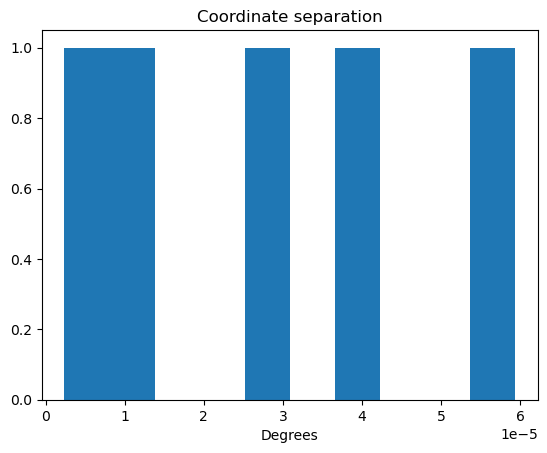

Median separation: 3.008232582414858e-05


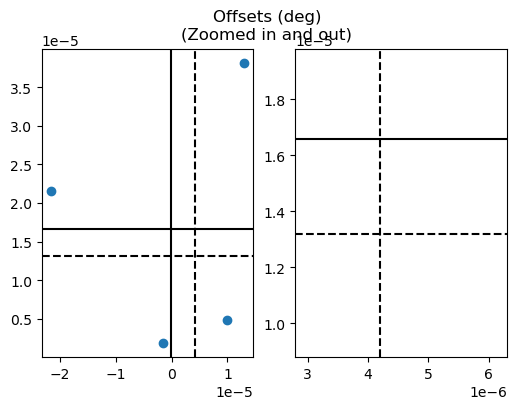

Median offsets in x and y (deg): 4.200780082896927e-06 1.3196894426137362e-05


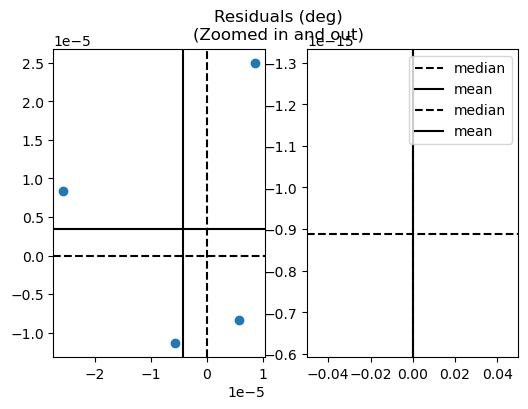


RESULTS OF ASTROMETRY CORRECTION

Median offsets in x and y:
 4.200780082896927e-06 1.3196894426137362e-05 degrees
 0.015122808298428936 0.047508819934094504 arcsecs

Standard deviation in x and y offsets:
 1.2978899093702518e-05 1.4543974358925133e-05 degrees
 0.04672403673732906 0.05235830769213048 arcsecs

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_astrocorrect_test_with_self_selected_sources.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_astrocorrect_test_with_self_selected_sources.reg saved!
Check region file for correct assessments.


(np.float64(4.200780082896927e-06),
 np.float64(1.3196894426137362e-05),
 np.float64(1.2978899093702518e-05),
 np.float64(1.4543974358925133e-05))

In [ ]:
base_coords = GetCoords(jwstdir+"M66_daofind_f200w_nircam_fk5.reg", [26518, 61697, 105008, 66102, 130187])
cat_coords = [M66_calibrators["RA"].values.tolist(), 
              M66_calibrators["Dec"].values.tolist()]
CorrectAstrometry(base_coords, cat_coords, returnshifts=True, autoresid=False,
                  savebasereg=chandradir+"M66_astrocorrect_test_with_self_selected_sources.reg")

In [38]:
4.200780082896927e-06 < 1.2978899093702518e-05

True

In [40]:
1.3196894426137362e-05 < 1.4543974358925133e-05

True

With these astrometric corrections, the standard deviation in the x and y median offsets are bigger than the median offsets so they do not need any correction and I can go forward with finding their positional uncertainties. 

## Calculating Positional Uncertainties

In [ ]:
M66_CSC = LoadSources(chandradir+"cscresults_M66_renamed.frame")
sig1, sig2 = CalcPU(M66_CSC, std=[0.04672, 0.05236])

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/cscresults_M66_renamed.frame...


In [66]:
sig1, sig2

([np.float64(0.09481995902844637),
  np.float64(0.09857235709184455),
  np.float64(0.093298891383214),
  np.float64(0.07017355627300072),
  np.float64(0.1395494679966451),
  np.float64(0.09742339075500348),
  np.float64(0.1872426323590418),
  np.float64(0.15132352925326215),
  np.float64(0.18706944728145644),
  np.float64(0.13908817096055845),
  np.float64(0.0900070838003553),
  np.float64(0.14594727386421058),
  np.float64(0.13598910832527164),
  np.float64(0.14033201048153454),
  np.float64(0.09842016375911845),
  np.float64(0.14701835963398743),
  np.float64(0.09772041119350867),
  np.float64(0.10617161082605497),
  np.float64(0.12297868797940799),
  np.float64(0.15344554145708333),
  np.float64(0.1887318540164987),
  np.float64(0.111805514000266),
  np.float64(0.15656841792730494),
  np.float64(0.20277687975380615),
  np.float64(0.22154733865225887),
  np.float64(0.20402950565665395),
  np.float64(0.2808712507396374),
  np.float64(0.1671268674439683),
  np.float64(0.221185247984320

In [65]:
sig1_test, sig2_test = CalcPU(M66_CSC, std=[0.04672, 0.05236], sig2search='Err Ellipse Major')
sig1_test, sig2_test

([np.float64(0.09481995902844637),
  np.float64(0.09857235709184455),
  np.float64(0.093298891383214),
  np.float64(1.7246388984362078),
  np.float64(0.1395494679966451),
  np.float64(0.09742339075500348),
  np.float64(0.1872426323590418),
  np.float64(0.15132352925326215),
  np.float64(0.18706944728145644),
  np.float64(0.13908817096055845),
  np.float64(0.0900070838003553),
  np.float64(0.14594727386421058),
  np.float64(0.13598910832527164),
  np.float64(0.14033201048153454),
  np.float64(0.09842016375911845),
  np.float64(0.14701835963398743),
  np.float64(0.09772041119350867),
  np.float64(0.10617161082605497),
  np.float64(0.12297868797940799),
  np.float64(0.15344554145708333),
  np.float64(0.1887318540164987),
  np.float64(0.111805514000266),
  np.float64(0.15656841792730494),
  np.float64(0.20277687975380615),
  np.float64(0.22154733865225887),
  np.float64(0.20402950565665395),
  np.float64(0.2808712507396374),
  np.float64(0.1671268674439683),
  np.float64(0.2211852479843208

In [76]:
for i in range(len(sig1)):
    if sig1[i] != sig1_test[i]:
        print(i)

for i in range(len(sig2)):
    if sig2[i] != sig2_test[i]:
        print(i)

3
53
3
53


In [73]:
print(f"{sig1[3]} and {sig1_test[3]}")
print(f"{sig2[3]} and {sig2_test[3]}")
print(f"{sig1[53]} and {sig1_test[53]}")
print(f"{sig2[53]} and {sig2_test[53]}")

0.07017355627300072 and 1.7246388984362078
0.14034711254600143 and 3.4492777968724155
0.07017355627300072 and 0.16289925533864305
0.14034711254600143 and 0.3257985106772861


I will be using the `sig1_test` and `sig2_test` sigma values for my analysis.

In [79]:
M66_CSC['1Sig'] = sig1_test # Saves sig1 to a new header called '1Sig'
M66_CSC['2Sig'] = sig2_test  # Saves sig2 to a new header called '2Sig'

# The new DataFrame has 1 and 2sig added at the end of the columns list
display(M66_CSC)

M66_CSC.to_csv(chandradir+'M66_csc_astrocorrected.frame')


,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641,0.094820,0.199755
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784,0.098572,0.211250
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017,0.093299,0.195763
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.724639,3.449278
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197,0.139549,0.319405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527,0.434283,1.063647
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982,0.418108,1.014080
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744,0.183118,0.383024
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118,0.431766,1.059103


## Selecting the best 2-$sigma$ radius per source

In [81]:
# Pulling the ID of each unique CSC source
ids = FindUnique(M66_CSC, header="CSC ID")["CSC ID"].values.tolist()

# Building an empty DataFrame, which I will fill below
M66_best = BuildFrame()

for i in ids: # for each unique ID pulled from CSC...
    
    # Search for all instances (i.e. observations) of each source
    Temp = Find(M66_CSC, "CSC ID = " + i)
    
    # Try to avoid sources where counts = NaN (invalid observations) 
    if len(Find(Temp, ["Counts != NaN", "Theta != NaN"])) > 0: 
        Temp = Find(Temp, ["Counts != NaN", "Theta != NaN"])
    
    # Specifically focus on those with a valid number of counts
    if len(Find(Temp, "Counts > 0")) > 0: 
        Temp = Find(Temp, ["Counts > 0"])
        
    # Otherwise, all instances with counts = 0 have the same measurements, 
    # so it doesn't matter which row is chosen for the best radii
    else: pass;
    
    # Take the source with the smallest 2sig. 
    # If there's more than one, take the first on the list.
    Tempbest = Find(Temp, "2Sig =< " + str(min(Temp["2Sig"]))).iloc[:1]
    
    # Add the chosen source observation to the new DataFrame
    M66_best = pd.concat([M66_best, Tempbest], ignore_index=True)

# Saving results to a DataFrame file
# This file contains only rows from M101_CSC that has the 
# best 2sigma radius, based on the search performed above
M66_best.to_csv(chandradir+"M66_csc_bestrads.frame")

display(M66_best)

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641,0.094820,0.199755
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784,0.098572,0.211250
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017,0.093299,0.195763
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.724639,3.449278
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197,0.139549,0.319405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527,0.434283,1.063647
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982,0.418108,1.014080
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744,0.183118,0.383024
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118,0.431766,1.059103


In [84]:
# Saving the region files as positional uncertainties
WriteReg(M66_best, radius=M66_best['2Sig'].values.tolist(), radunit='arcsec', \
         idheader="CSC ID", outfile=chandradir+'/M66_bestrads_2sig.reg')
WriteReg(M66_best, radius=M66_best['1Sig'].values.tolist(), radunit='arcsec', \
         outfile=chandradir+'M66_bestrads_1sig.reg')

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra//M66_bestrads_2sig.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra//M66_bestrads_2sig.reg saved!
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_bestrads_1sig.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/M66_bestrads_1sig.reg saved!


# Astrometric Corrections (HST)

In [72]:
M66_CSC = LoadSources(chandra_hst_dir+"cscresults_M66_renamed.frame")
M66_unique = FindUnique(M66_CSC, header="CSC ID")
WriteReg(M66_unique, outfile=chandra_hst_dir+"M66_cscsources.reg", idheader="CSC ID", 
         radius=5, radunit="arcsec", width=2, color="hotpink")

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/cscresults_M66_renamed.frame...
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_cscsources.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_cscsources.reg saved!


In [83]:
M66_calibrators = ["2CXO J112014.8+125814",
                   "2CXO J112018.9+130135",
                   "2CXO J112019.1+125947", # Not sure about this (upper left corner)
                   "2CXO J112019.5+125958", # Not sure about this (upper left corner)
                   "2CXO J112018.8+125924",
                  ] 
print(f"{len(M66_calibrators)} calibrators to match")

M66_calibrators = RemoveElse(M66_unique, keep=M66_calibrators, header='CSC ID')
print(f"{len(M66_calibrators)} calibrators found")

WriteReg(M66_calibrators, outfile=chandra_hst_dir+"M66_calibrators.reg")

5 calibrators to match
5 calibrators found
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_calibrators.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_calibrators.reg saved!


Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/M66_daofind_f555w_wfc3_fk5.reg


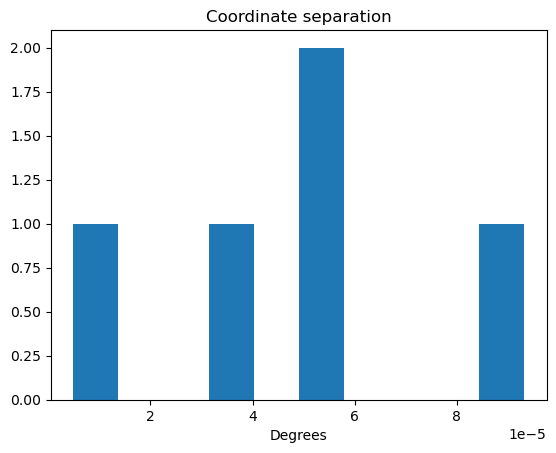

Median separation: 5.018053570045068e-05


Input min and max separation: 0, 9.6e-5


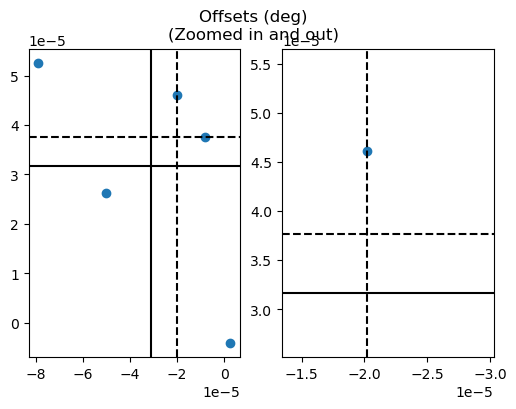

Median offsets in x and y (deg): -2.018614964072185e-05 3.766607498967289e-05


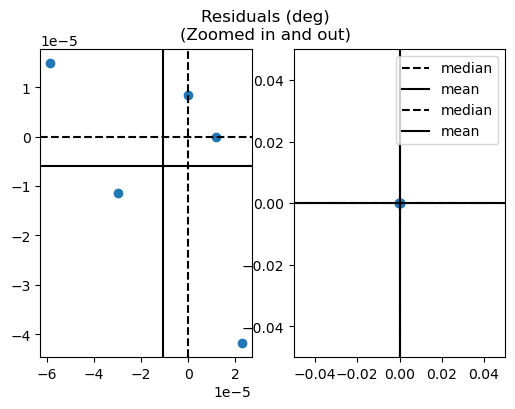

Min and max x residuals: -3e-5, 2.2e-5
Min and max y residuals: -4.2e-5, 1.6e-5



RESULTS OF ASTROMETRY CORRECTION

Median offsets in x and y:
 -2.018614964072185e-05 3.766607498967289e-05 degrees
 -0.07267013870659866 0.13559786996282241 arcsecs

Standard deviation in x and y offsets:
 1.7643739978865733e-05 1.9961232387211725e-05 degrees
 0.06351746392391663 0.07186043659396221 arcsecs

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_astrocorrect.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_astrocorrect.reg saved!
Check region file for correct assessments.


(np.float64(-2.018614964072185e-05),
 np.float64(3.766607498967289e-05),
 np.float64(1.7643739978865733e-05),
 np.float64(1.9961232387211725e-05))

In [84]:
base_coords = GetCoords(hstdir+"M66_daofind_f555w_wfc3_fk5.reg")
cat_coords = [M66_calibrators["RA"].values.tolist(),
              M66_calibrators["Dec"].values.tolist()]

CorrectAstrometry(base_coords, cat_coords, returnshifts=True,
                 savebasereg=chandra_hst_dir+"M66_astrocorrect.reg")

Assuming that the above astrometric corrections and its outputs are correct, since the standard deviations in the x and y offsets are bigger than their corresponding median offsets, there is not any correction needed between them. 

### Testing astrometric corrections

In [89]:
# testing
M66_calibrators_test = ["2CXO J112014.8+125814",
                   "2CXO J112018.9+130135",
                  # "2CXO J112019.1+125947", # Not sure about this (upper left corner)
                   #"2CXO J112019.5+125958", # Not sure about this (upper left corner)
                   #"2CXO J112018.8+125924",
                   "2CXO J112018.3+125900"
                  ] 
print(f"{len(M66_calibrators_test)} calibrators to match")

M66_calibrators_test = RemoveElse(M66_unique, keep=M66_calibrators_test, header='CSC ID')
print(f"{len(M66_calibrators_test)} calibrators found")

WriteReg(M66_calibrators_test, outfile=chandra_hst_dir+"M66_calibrators_test.reg")

3 calibrators to match
3 calibrators found
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_calibrators_test.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_calibrators_test.reg saved!


Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/M66_daofind_f555w_wfc3_fk5.reg


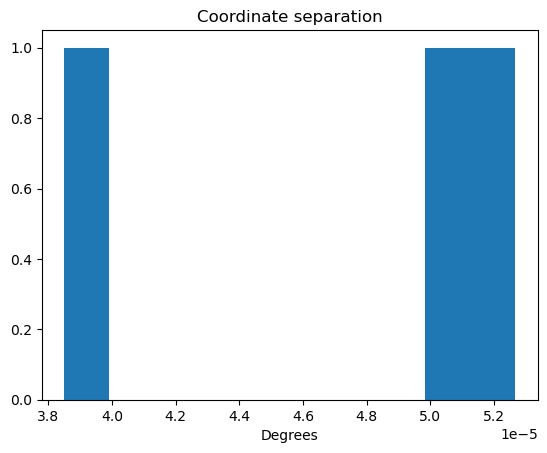

Median separation: 5.018053570045068e-05


Input min and max separation: 3.85e-5, 5.4e-5


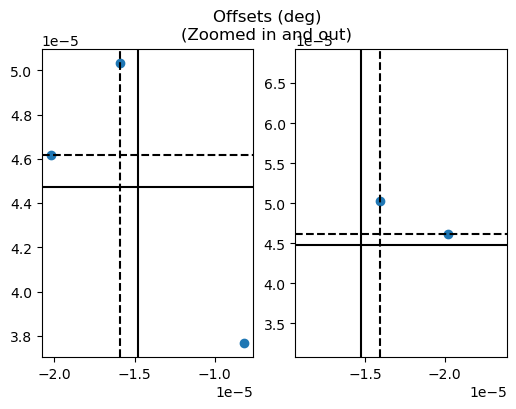

Median offsets in x and y (deg): -1.593346757999825e-05 4.616420678260624e-05


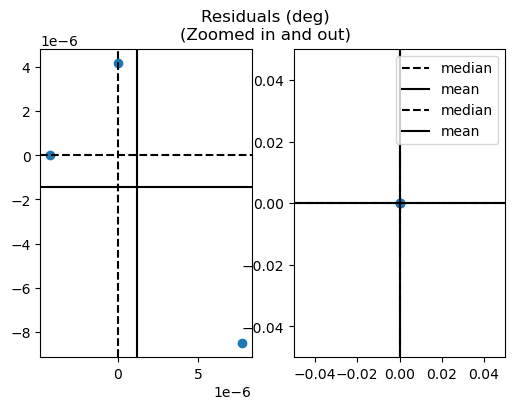


RESULTS OF ASTROMETRY CORRECTION

Median offsets in x and y:
 -1.593346757999825e-05 4.616420678260624e-05 degrees
 -0.0573604832879937 0.16619114441738247 arcsecs

Standard deviation in x and y offsets:
 4.967295010534421e-06 5.26939924450599e-06 degrees
 0.017882262037923917 0.01896983728022156 arcsecs

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_astrocorrect_test.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_astrocorrect_test.reg saved!
Check region file for correct assessments.


(np.float64(-1.593346757999825e-05),
 np.float64(4.616420678260624e-05),
 np.float64(4.967295010534421e-06),
 np.float64(5.26939924450599e-06))

In [91]:
base_coords_test = GetCoords(hstdir+"M66_daofind_f555w_wfc3_fk5.reg")
cat_coords_test = [M66_calibrators_test["RA"].values.tolist(),
              M66_calibrators_test["Dec"].values.tolist()]

CorrectAstrometry(base_coords_test, cat_coords_test, returnshifts=True,
                 savebasereg=chandra_hst_dir+"M66_astrocorrect_test.reg", autoresid=True)

## Calculating Positional Uncertainties

In [94]:
sig1, sig2 = CalcPU(M66_CSC, std=[0.06352,0.07186], sig2search='Err Ellipse Major')

In [96]:
M66_CSC['1Sig'] = sig1  # Saves sig1 to a new header called '1Sig'
M66_CSC['2Sig'] = sig2  # Saves sig2 to a new header called '2Sig'

# The new DataFrame has 1 and 2sig added at the end of the columns list
display(M66_CSC)

M66_CSC.to_csv(chandra_hst_dir+'M66_csc_astrocorrected.frame')

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641,0.115174,0.238746
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784,0.118283,0.248443
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017,0.113925,0.235415
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.725878,3.451755
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197,0.154105,0.345133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527,0.439176,1.071654
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982,0.423189,1.022475
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744,0.194439,0.404728
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118,0.436688,1.067144


In [98]:
# Pulling the ID of each unique CSC source
ids = FindUnique(M66_CSC, header="CSC ID")["CSC ID"].values.tolist()

# Building an empty DataFrame, which I will fill below
M66_best = BuildFrame()

for i in ids: # for each unique ID pulled from CSC...
    
    # Search for all instances (i.e. observations) of each source
    Temp = Find(M66_CSC, "CSC ID = " + i)
    
    # Try to avoid sources where counts = NaN (invalid observations) 
    if len(Find(Temp, ["Counts != NaN", "Theta != NaN"])) > 0: 
        Temp = Find(Temp, ["Counts != NaN", "Theta != NaN"])
    
    # Specifically focus on those with a valid number of counts
    if len(Find(Temp, "Counts > 0")) > 0: 
        Temp = Find(Temp, ["Counts > 0"])
        
    # Otherwise, all instances with counts = 0 have the same measurements, 
    # so it doesn't matter which row is chosen for the best radii
    else: pass;
    
    # Take the source with the smallest 2sig. 
    # If there's more than one, take the first on the list.
    Tempbest = Find(Temp, "2Sig =< " + str(min(Temp["2Sig"]))).iloc[:1]
    
    # Add the chosen source observation to the new DataFrame
    M66_best = pd.concat([M66_best, Tempbest], ignore_index=True)

# Saving results to a DataFrame file
# This file contains only rows from M101_CSC that has the 
# best 2sigma radius, based on the search performed above
M66_best.to_csv(chandra_hst_dir+"M66_csc_bestrads.frame")

display(M66_best)

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,NaN,NaN,NaN,0.420311,0.029981,173.048934,154.988228,191.109641,0.115174,0.238746
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,NaN,NaN,NaN,0.412041,-0.277327,126.386565,109.441688,142.201784,0.118283,0.248443
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,NaN,NaN,NaN,0.488407,0.224859,226.842541,209.119065,244.566017,0.113925,0.235415
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,NaN,NaN,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.725878,3.451755
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,NaN,NaN,NaN,0.477466,0.199875,39.229231,31.383385,46.639197,0.154105,0.345133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,NaN,NaN,NaN,3.984317,0.201124,18.342335,13.057255,23.316527,0.439176,1.071654
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,NaN,NaN,NaN,4.338261,0.463460,24.421586,18.316189,30.526982,0.423189,1.022475
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,NaN,NaN,NaN,4.414767,0.763273,150.478203,136.047662,164.908744,0.194439,0.404728
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,NaN,NaN,NaN,3.872333,-0.408495,17.434501,12.141885,22.727118,0.436688,1.067144


In [100]:
# Saving the positional uncertainties as region files
WriteReg(M66_best, radius=M66_best['2Sig'].values.tolist(), radunit='arcsec', \
         idheader="CSC ID", outfile=chandra_hst_dir+'M66_bestrads_2sig.reg')
WriteReg(M66_best, radius=M66_best['1Sig'].values.tolist(), radunit='arcsec', \
         outfile=chandra_hst_dir+'M66_bestrads_1sig.reg')

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_bestrads_2sig.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_bestrads_2sig.reg saved!
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_bestrads_1sig.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_bestrads_1sig.reg saved!


# Identifying Optical Counterparts to X-ray sources
Date: 29 May 2025 <br>
I will only be doing JWST in this document.

## Isolating Candidate Counterparts with `DaoClean`

From my inspection, I can see that the image coordinates of f200w does not align well with the rgb image. I do not know if there is a way for me to align them either. But, for now, I will move on with using fk5 coordinates even though their results are not very predictable for `DaoClean`

In [3]:
x,y = GetCoords(jwstdir+"M66_daofind_f200w_nircam_img.reg")
ids = GetIDs(jwstdir+"M66_daofind_f200w_nircam_img.reg")
ra,dec = GetCoords(jwstdir+"M66_daofind_f200w_nircam_fk5.reg")

# # Compiling into a single DataFrame
DaoFrame = BuildFrame(headers=['DaoID','X','Y','RA','Dec'], 
                      values=[ids,x,y,ra,dec])
DaoFrame.to_csv(jwstdir+"M66_daofind_nircam_coords.frame")

Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/M66_daofind_f200w_nircam_img.reg
Retrieving IDs from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/M66_daofind_f200w_nircam_img.reg
Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/M66_daofind_f200w_nircam_fk5.reg


In [4]:
DaoFrame = pd.read_csv(jwstdir+"M66_daofind_nircam_coords.frame").drop("Unnamed: 0", axis=1)
display(DaoFrame)

,DaoID,X,Y,RA,Dec
0,1,2924.060015,17.233289,170.063905,12.942310
1,2,2935.948938,16.743024,170.063801,12.942306
2,3,2940.043395,24.122714,170.063765,12.942369
3,4,2913.002787,24.673854,170.064002,12.942374
4,5,2928.996433,27.917984,170.063862,12.942402
...,...,...,...,...,...
338489,338490,4209.310007,9462.788748,170.052636,13.022988
338490,338491,4182.418343,9464.476210,170.052871,13.023002
338491,338492,4217.247604,9468.846438,170.052566,13.023040
338492,338493,4190.522509,9471.099783,170.052800,13.023059


>**IMPORTANT**:

I am using the conversion rate of short wavelength filter. I think this will be good since the pixel value will be bigger (since 0.031 < 0.062) and it's better to be more conservative here, especially since this is the first time this is being done with JWST.

In [5]:
cd(chandra_jwst_dir)
M66_best = LoadSources("M66_csc_bestrads.frame")

# Reading in the newly-saved img region file
xsources, ysources = GetCoords("M66_bestrads_2sig_img.reg")
# Adding the image coordinates to the DataFrame
M66_best["X"] = xsources
M66_best["Y"] = ysources

# Convert the radius from arcseconds to pixels. 
# The conversion is 0.05 for ACS/WFC and 0.03962 for WFC3/UVIS
# The conversion is 0.031 for short wavelength and 0.062 for long wavelength
# filters in JWST
M66_best["2Sig (pix)"] = M66_best["2Sig"] / 0.031  # f200w is a short wavelength filter

# Saving the changes to the DataFrame
M66_best.to_csv("M66_csc_bestrads.frame")
display(M66_best)

Reading in sources from M66_csc_bestrads.frame...
Retrieving coordinates from M66_bestrads_2sig_img.reg


,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix)
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,0.420311,0.029981,173.048934,154.988228,191.109641,0.094820,0.199755,3092.46810,5775.61640,6.443720
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,0.412041,-0.277327,126.386565,109.441688,142.201784,0.098572,0.211250,3041.08760,5756.21730,6.814523
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,0.488407,0.224859,226.842541,209.119065,244.566017,0.093299,0.195763,3111.69780,5908.85640,6.314923
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.724639,3.449278,2951.33130,5856.84300,111.267026
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,0.477466,0.199875,39.229231,31.383385,46.639197,0.139549,0.319405,2899.58940,5861.66790,10.303379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,3.984317,0.201124,18.342335,13.057255,23.316527,0.434283,1.063647,-4325.77070,7200.90170,34.311184
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,4.338261,0.463460,24.421586,18.316189,30.526982,0.418108,1.014080,6174.97000,12849.63500,32.712258
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,4.414767,0.763273,150.478203,136.047662,164.908744,0.183118,0.383024,890.15421,13277.38300,12.355608
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,3.872333,-0.408495,17.434501,12.141885,22.727118,0.431766,1.059103,-3032.91700,566.64695,34.164619


In [6]:
DaoCleanFrame = DaoClean(daosources=DaoFrame, sources=M66_best, sourceid="CSC ID", 
                         coordsys="fk5", coordheads=['RA', 'Dec'], radheader="2Sig") 

# Renaming the DaoID header to "F555W ID", to match the output of the other filters
DaoCleanFrame = DaoCleanFrame.rename(columns={'DaoID': 'F200W ID'})

display(DaoCleanFrame)

WriteReg(DaoCleanFrame, coordsys='fk5', width=2,
         outfile='M66_daoclean_f200w_nircam_fk5.reg',
         radius=0.1, radunit='arcsec')

Cleaning DAOFind sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


,F200W ID,X,Y,RA,Dec,CSC ID
0,186126,3095.278143,5769.996064,170.062403,12.991447,2CXO J112014.9+125929
1,186591,3098.298769,5777.274662,170.062377,12.991509,2CXO J112014.9+125929
2,185199,3035.930921,5754.396561,170.062923,12.991314,2CXO J112015.0+125928
3,185366,3042.938275,5757.419244,170.062862,12.991339,2CXO J112015.0+125928
4,185433,3035.951387,5759.029222,170.062923,12.991353,2CXO J112015.0+125928
...,...,...,...,...,...,...
1353,26276,4034.543404,2097.590954,170.054172,12.960079,2CXO J112013.0+125736
1354,26305,4021.687783,2099.17956,170.054284,12.960093,2CXO J112013.0+125736
1355,26519,4032.312552,2109.128343,170.054191,12.960178,2CXO J112013.0+125736
1356,26624,4024.074667,2114.406991,170.054263,12.960223,2CXO J112013.0+125736


Saving M66_daoclean_f200w_nircam_fk5.reg
M66_daoclean_f200w_nircam_fk5.reg saved!


In [1]:
cd(jwstdir)
regions = ['M66_daofind_f300m_nircam_fk5.reg',
           'M66_daofind_f335m_nircam_fk5.reg',
           'M66_daofind_f360m_nircam_fk5.reg']
DaoCleanMatch = Crossref(DaoCleanFrame, 
                         regions=regions, 
                         catalogs=['F300M', 'F335M', 'F360M'], coordheads=['RA','Dec'], coordsys='fk5',
                         sourceid="F200W ID", outfile=chandra_jwst_dir+"M66_daoclean_matches.frame",
                         search_radius=0.00005)

DaoCleanMatch

NameError: name 'cd' is not defined

In [26]:
DaoCleanMatch["CSC ID"] = None

# Adding the CSC IDs of each source the daosources are associated with
for i in range(len(DaoCleanMatch)): 
    # Searches for the CSC ID associated with each F555W ID (DaoID in DaoCleanFrame)
    tempid = DaoCleanMatch["F200W ID"][i] 
    tempcsc = Find(DaoCleanFrame, "F200W ID = " + str(tempid))["CSC ID"][0]
    DaoCleanMatch["CSC ID"][i] = tempcsc
    
# Updating the DataFrame
DaoCleanMatch.to_csv(chandra_jwst_dir+"M66_daoclean_matches.frame")
display(DaoCleanMatch)

,RA,Dec,F200W ID,F300M ID,F335M ID,F360M ID,CSC ID
0,170.062403,12.991447,186126,43256,39563,NaN,2CXO J112014.9+125929
1,170.062377,12.991509,186591,43256,NaN,45349,2CXO J112014.9+125929
2,170.062923,12.991314,185199,42999,39292,44947,2CXO J112015.0+125928
3,170.062862,12.991339,185366,43115,39406,45067,2CXO J112015.0+125928
4,170.062923,12.991353,185433,NaN,NaN,NaN,2CXO J112015.0+125928
...,...,...,...,...,...,...,...
1428,170.054172,12.960079,26276,NaN,NaN,NaN,2CXO J112013.0+125736
1429,170.054284,12.960093,26305,NaN,NaN,NaN,2CXO J112013.0+125736
1430,170.054191,12.960178,26519,6497,5610,6873,2CXO J112013.0+125736
1431,170.054263,12.960223,26624,NaN,5634,6902,2CXO J112013.0+125736


In [ ]:
# check results of cross reference. This was not very helpful.
regions=[jwstdir+'M66_daofind_f360m_nircam_fk5.reg',
        jwstdir+'M66_daofind_f335m_nircam_fk5.reg',
        jwstdir+'M66_daofind_f300m_nircam_fk5.reg',
        jwstdir+'M66_daofind_f200w_nircam_fk5.reg'] 

M66_sources = LoadSources(chandra_jwst_dir+'M66_csc_bestrads.frame')

# /Applications/SAOImageDS9.app/Contents/MacOS/ds9 
# the above path works
WriteDS9(df=M66_sources, galaxy='M66', colorfiles=[f360m, f335m, f200w],
         regions=regions, basefilter=['blue'], zoom=7, idheader='CSC ID',
         filetype='png', outfile=chandra_jwst_dir+'M66_cross_ref.sh',
         imgnames='img')

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix)
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,0.420311,0.029981,173.048934,154.988228,191.109641,0.094820,0.199755,170.062428,12.991495,6.443720
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,0.412041,-0.277327,126.386565,109.441688,142.201784,0.098572,0.211250,170.062878,12.991329,6.814523
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,0.488407,0.224859,226.842541,209.119065,244.566017,0.093299,0.195763,170.062259,12.992633,6.314923
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.724639,3.449278,170.063665,12.992189,111.267026
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,0.477466,0.199875,39.229231,31.383385,46.639197,0.139549,0.319405,170.064119,12.992230,10.303379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,3.984317,0.201124,18.342335,13.057255,23.316527,0.434283,1.063647,170.127457,13.003663,34.311184
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,4.338261,0.463460,24.421586,18.316189,30.526982,0.418108,1.014080,170.035399,13.051914,32.712258
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,4.414767,0.763273,150.478203,136.047662,164.908744,0.183118,0.383024,170.081736,13.055570,12.355608
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,3.872333,-0.408495,17.434501,12.141885,22.727118,0.431766,1.059103,170.116113,12.946999,34.164619


Writing /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_cross_ref.sh...
DONE


In [29]:
tempcsc = DaoCleanMatch["CSC ID"][0] # Keeping track of the current X-ray source
DaoCleanMatch["StarID"] = None # Storing the star number for each X-ray source

starno = 1 # Star number counter

for i in range(len(DaoCleanMatch)): 
    # If this is a new CSC ID, save it to tempcsc and restart starno counter
    if tempcsc != DaoCleanMatch["CSC ID"][i]: 
        tempcsc = DaoCleanMatch["CSC ID"][i]
        starno = 1
    DaoCleanMatch["StarID"][i] = starno
    starno += 1 # adds one to the starno counter

# Saving the candidate region file with new numberings
WriteReg(DaoCleanMatch, coordsys="fk5", coordheads=["RA","Dec"], 
         idheader="StarID", width=2, fontsize=12, radius=0.05,
         radunit='arcsec', outfile=chandra_jwst_dir+"M66_XRB_candidates.reg")

# DaoCleanMatch has now renumbered each star associated with 
# an X-ray source for simplicity
display(DaoCleanMatch)

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_XRB_candidates.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_XRB_candidates.reg saved!


,RA,Dec,F200W ID,F300M ID,F335M ID,F360M ID,CSC ID,StarID
0,170.062403,12.991447,186126,43256,39563,NaN,2CXO J112014.9+125929,1
1,170.062377,12.991509,186591,43256,NaN,45349,2CXO J112014.9+125929,2
2,170.062923,12.991314,185199,42999,39292,44947,2CXO J112015.0+125928,1
3,170.062862,12.991339,185366,43115,39406,45067,2CXO J112015.0+125928,2
4,170.062923,12.991353,185433,NaN,NaN,NaN,2CXO J112015.0+125928,3
...,...,...,...,...,...,...,...,...
1428,170.054172,12.960079,26276,NaN,NaN,NaN,2CXO J112013.0+125736,2
1429,170.054284,12.960093,26305,NaN,NaN,NaN,2CXO J112013.0+125736,3
1430,170.054191,12.960178,26519,6497,5610,6873,2CXO J112013.0+125736,4
1431,170.054263,12.960223,26624,NaN,5634,6902,2CXO J112013.0+125736,5


# Classifying Optical Sources
Date: 2 June 2025

Scalings :
20.0 23.0 25.0 2989.82 4713.85 4176.74 8066.37
15.0 15.0 20 2123.82 4217.01 4700.59 7322.84
20.0 20.0 27.0 2584.77 3844.51 5256.15 6392.66

In [4]:
M66_best

,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix),ID
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,0.029981,173.048934,154.988228,191.109641,0.094820,0.199755,170.062428,12.991495,6.443720,CXO001
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,-0.277327,126.386565,109.441688,142.201784,0.098572,0.211250,170.062878,12.991329,6.814523,CXO002
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,0.224859,226.842541,209.119065,244.566017,0.093299,0.195763,170.062259,12.992633,6.314923,CXO003
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,NaN,3329.616280,3231.522180,3427.710381,1.724639,3.449278,170.063665,12.992189,111.267026,CXO004
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,0.199875,39.229231,31.383385,46.639197,0.139549,0.319405,170.064119,12.992230,10.303379,CXO005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,0.201124,18.342335,13.057255,23.316527,0.434283,1.063647,170.127457,13.003663,34.311184,CXO084
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,0.463460,24.421586,18.316189,30.526982,0.418108,1.014080,170.035399,13.051914,32.712258,CXO085
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,0.763273,150.478203,136.047662,164.908744,0.183118,0.383024,170.081736,13.055570,12.355608,CXO086
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,-0.408495,17.434501,12.141885,22.727118,0.431766,1.059103,170.116113,12.946999,34.164619,CXO087


In [10]:
M66_best = LoadSources(chandra_jwst_dir+'M66_csc_bestrads.frame')

M66_best['ID'] = ["CXO%03d" % (i+1) for i in range(len(M66_best))]

WriteScalings(M66_best, outfile=chandra_jwst_dir+"M66_XRB_scalings.txt", 
              scalings=chandra_jwst_dir+"autoscalings.txt", idheader="ID")

cd(chandra_jwst_dir)
WriteDS9(M66_best, galaxy='M66', zoom=7,
        unique_scale=True, scales='M66_XRB_scalings.txt',
        regions=['M66_XRB_candidates.reg',
                 'M66_bestrads_1sig.reg',
                 'M66_bestrads_2sig.reg'],
        colorfiles=[jwstdir+'hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits',
                    jwstdir+'hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits',
                    jwstdir+'hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits'],
        basefilter=['green'], imgnames='XRB_images/M66_XRB_candidates',
        outfile='M66_XRB_candidates.sh', idheader='ID', filetype='png')
        # path_to_ds9="/Applications/SAOImageDS9.app/Contents/MacOS/ds9")

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_csc_bestrads.frame...
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_XRB_scalings.txt saved
DONE.
Writing M66_XRB_candidates.sh...
DONE
